<a href="https://colab.research.google.com/github/tarod13/CardGames/blob/main/BlackJack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

semilla = 0
np.random.seed(semilla)

In [83]:
def number2card(number):
  invalid_flag = False
  
  rank = (number % 13) + 1
  if rank < 1 or rank > 13:
    invalid_flag = True
  elif rank == 1:
    rank = 'A'
  elif rank == 11:
    rank = 'J'
  elif rank == 12:
    rank = 'Q'
  elif rank == 13:
    rank = 'K'
  else:
    rank = str(int(rank))
  
  symbol = number // 13
  if symbol == 0:
    symbol = 'clubs'
  elif symbol == 1:
    symbol = 'diamonds'
  elif symbol == 2:
    symbol = 'hearts'
  elif symbol == 3:
    symbol = 'spades'
  else:
    invalid_flag = True

  assert not invalid_flag, 'Invalid number'

  return (rank, symbol)


def card2value(card):
  rank = card[0]
  
  if rank == 'A':
    value = 1    
  elif rank in ['J', 'Q', 'K']:
    value = 10
  elif int(rank) > 1 and int(rank) <= 10:
    value = int(rank)
  else:
    print(rank)
    raise NameError('Invalid card')
  
  return value

In [84]:
class BlackJackEnv():
  def __init__(self, seed=0):    
    self.seed(seed)
    self.actions = {'0':'stand', '1': 'hit'}
    
  def step(self, action):
    state = [list(self.player_hand).copy(), self.visible_dealer_card]

    if action == 0:
      sum_dealer, n_aces_dealer = self.calculate_sum(who='dealer')
      score_dealer = self.calculate_score(sum_dealer, n_aces_dealer)
      sum_player, n_aces_player = self.calculate_sum()
      score_player = self.calculate_score(sum_player, n_aces_player)
      
      if (score_player == 21) and (len(self.player_hand) == 2):
        if score_dealer == 21:
          reward = 0.0
        else:
          reward = 1.0
      else:
        while score_dealer < 17:
          new_dealer_card = set(random.sample(self.deck, 1))        
          self.deck = self.deck.difference(new_dealer_card)
          self.dealer_hand = self.dealer_hand.union(new_dealer_card)
          sum_dealer, n_aces_dealer = self.calculate_sum(who='dealer')
          score_dealer = self.calculate_score(sum_dealer, n_aces_dealer)
        
        dealer_went_bust = score_dealer > 21
        player_went_bust = score_player > 21
        if player_went_bust:
          reward = -1.0
        elif dealer_went_bust or (score_player > score_dealer):
          reward = 1.0
        elif score_player == score_dealer:
          reward = 0.0
        else:
          reward = -1.0
        
      done = True      

    elif action == 1:
      new_player_card = set(random.sample(self.deck, 1))
      self.deck = self.deck.difference(new_player_card)
      self.player_hand = self.player_hand.union(new_player_card)
      sum_player, n_aces_player = self.calculate_sum()
      went_bust = sum_player > 21      
      if went_bust:
        reward = -1.0
        done = True        
      else:
        reward = 0.0
        done = False        

    else:
      raise NameError('Invalid action')
    
    if done:    
      next_state = [list(self.player_hand).copy(), list(self.dealer_hand).copy()]
    else:
      next_state = [list(self.player_hand).copy(), self.visible_dealer_card]
    return state, next_state, reward, done 

  def seed(self, seed=None):
    random.seed(seed)

  
  def reset(self):
    self.deck = set(range(0,52))
    self.deck = set([number2card(x) for x in self.deck])

    self.player_hand = set(random.sample(self.deck, 2))
    self.deck = self.deck.difference(self.player_hand)
    self.dealer_hand = set(random.sample(self.deck, 2))
    self.deck = self.deck.difference(self.dealer_hand)

    self.visible_dealer_card = set(random.sample(self.dealer_hand, 1)).pop()
    state = [list(self.player_hand).copy(), self.visible_dealer_card]
    return state


  @staticmethod
  def calculate_score(sum_no_aces, n_aces):
    score = sum_no_aces
    soft_hand = (21 - sum_no_aces) >= 10
    at_least_one_ace = n_aces > 0
    if soft_hand and at_least_one_ace:
      score += 10
    return score

  
  def calculate_sum(self, who='player'):
    n_aces = 0
    sum_ = 0
    
    if who == 'player':
      hand = self.player_hand
    else:
      hand = self.dealer_hand
    
    for card in hand:  
      rank = card[0]
      if rank == 'A':
        n_aces += 1          
      sum_ += card2value(card)
    
    return sum_, n_aces

class Agent():
  def __init__(self, size_state=(10,10,2), size_action=(2,)):    
    self.q_function = np.zeros(size_state+size_action)
    self.n_visit = np.zeros(size_state+size_action)
    self.exploration_factors = np.ones(size_state) 
    self.n_actions = size_action[0]
  
  @staticmethod
  def state2code(state):
    n_aces = 0
    sum_ = 0
    
    player_hand, dealer_card = state
    
    for card in player_hand:  
      rank = card[0]
      if rank == 'A':
        n_aces += 1          
      sum_ += card2value(card)
  
    visible_score_dealer = card2value(dealer_card)
    soft_hand = (21 - sum_) >= 10
    usable_ace = (n_aces > 0)  and soft_hand
    return sum_, visible_score_dealer, usable_ace

  def transform_state(self, state):
    sum_hand, score_dealer, usable_ace = self.state2code(state)
    score = sum_hand + 10*usable_ace      
    if score < 12:
      s_0 = s_1 = s_2 = None
    else:      
      s_0 = int(score-12)
      s_1 = int(score_dealer-1)
      s_2 = int(usable_ace)    
    return s_0, s_1, s_2

  def sample_epsilon_policy(self, state, epsilon):
    s_0, s_1, s_2 = state
    q_values = self.q_function[s_0, s_1, s_2, :]
    if np.random.rand() > epsilon:
      possible_actions = q_values.argmax()
      if isinstance(possible_actions, np.int64):
        action = possible_actions
      else:
        action = random.choice(possible_actions)
    else:
      action = np.random.randint(0, high=self.n_actions)
    return action
  
  def select_action(self, state, epsilon):
    transformed_state = self.transform_state(state)
    if transformed_state[0] is not None:
      action = self.sample_epsilon_policy(transformed_state, epsilon)
    else:
      action = 1 # 'Hit' if sum is less than 12
    return action, transformed_state
  
  def update(self, transformed_state, action, displacement, alpha):
    state_action_pair_id = transformed_state + (action,)
    # Update of # of times that state-action pair is visited
    self.n_visit[state_action_pair_id] += 1            
    # Update of value function
    self.q_function[state_action_pair_id] += alpha * displacement

In [85]:
juego = BlackJackEnv(seed=semilla)
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)
m, nm, r, d = juego.step(0)
print('Nueva mano: ', nm)
print('Recompensa: ', r)
print('Juego terminado: ', d)

Mano inicial:  [[('Q', 'spades'), ('A', 'diamonds')], ('K', 'diamonds')]
Nueva mano:  [[('Q', 'spades'), ('A', 'diamonds')], [('10', 'diamonds'), ('K', 'diamonds')]]
Recompensa:  1.0
Juego terminado:  True


In [86]:
def entrenar_agente_MonteCarlo(juego, agente, alpha, epsilon, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000):  
  for episodio in range(0, n_episodios):
    terminado = False    
    trayectoria = []
    estado = juego.reset()

    while not terminado:   
      # El agente toma una accion
      accion, estado_transformado = agente.select_action(estado, epsilon)
      _, siguiente_estado, recompensa, terminado = juego.step(accion)

      # Se añade el paso a la trayectoria
      estado = siguiente_estado.copy()  
      trayectoria.append([estado_transformado, accion, recompensa, terminado])

    retorno = 0
    for i in range(0,len(trayectoria)):
      estado, accion, recompensa, terminado = trayectoria.pop()
      retorno = recompensa + beta * retorno

      # Se actualiza la funcion q del agente
      if estado[0] is not None:
        indice_estado_accion = estado + (accion,) 
        cambio_funcion_q = retorno - agente.q_function[indice_estado_accion]       
        agente.update(estado, accion, cambio_funcion_q, alpha)

    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

In [87]:
def entrenar_agente_SARSA(juego, agente, alpha, epsilon, n_episodios,
                    imprimir=False, imprimir_cada_ep=5000):
  for episodio in range(0, n_episodios):
    terminado = False    
    estado = juego.reset()

    while not terminado:   
      # El agente toma una accion
      accion, estado_transformado = agente.select_action(estado, epsilon)
      _, siguiente_estado, recompensa, terminado = juego.step(accion)

      if estado[0] is not None:
        # Se estima la recompensa futura. Si el juego se termino, esta es 0
        if not terminado: 
          # Se codifica el siguiente estado y se calcula la siguiente accion
          siguiente_accion, siguiente_estado_transformado = agente.select_action(siguiente_estado, epsilon)
          indice_siguiente_estado_accion = siguiente_estado_transformado + (accion)

          estimado_recompensa_futura = agente.q_function[indice_siguiente_estado_accion]
        else:
          estimado_recompensa_futura = 0
      
        # Se calcula el error de diferencia temporal
        estimado_Bellman = recompensa + beta * estimado_recompensa_futura
        indice_estado_accion = estado_transformado + (accion,)
        error_dt = estimado_Bellman - funcion_q[indice_estado_accion]

        # Se actualiza la funcion q del agente
        agente.update(estado, accion, cambio_funcion_q, alpha)
    
    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

In [88]:
def evaluar_agente(juego, agente, n_episodios, epsilon, 
                   imprimir=False, ciclo=0):
  retornos = []
  for episodio in range(0, n_episodios):
    terminado = False
    retorno = 0
    estado = juego.reset()

    paso = 0
    while not terminado:
      accion = agente.select_action(estado, epsilon)[0]
      _, siguiente_estado, recompensa, terminado = juego.step(accion)
      retorno = retorno + (beta**paso) * recompensa
      estado = siguiente_estado.copy()
      paso += 1  
      
    retornos.append(retorno)
  retornos = np.array(retornos)
  retorno_promedio = retornos.mean()
  desviacion_retorno = retornos.std()
  if imprimir:
    print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
  return retorno_promedio, desviacion_retorno

In [89]:
def entrenar_agente(juego, agente, metodo, alpha, epsilon, 
                    n_ciclos, n_episodios_ent, n_episodios_eval):
  # Se crean listas de desempeño
  retornos_media = []
  retornos_desviacion = []

  # Se ejecuta ciclo de entrenamiento y evaluacion una cantidad n_ciclos de veces
  for ciclo in range(0, n_ciclos):
    entrenamiento = metodos_de_entrenamiento[metodo]
    entrenamiento(juego, agente, alpha, epsilon, n_episodios_ent)
    G_promedio, G_desviacion = evaluar_agente(juego, agente, n_episodios_eval, epsilon,
                              imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1)
    retornos_media.append(G_promedio)
    retornos_desviacion.append(G_desviacion)
    epsilon = max(min_epsilon, epsilon * decaimiento_epsilon)  
  return retornos_media, retornos_desviacion

In [90]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 400
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decaimiento_epsilon = 0.98 # 1.0-1e-3
beta = 1.0
alpha = 0.001
imprimir_cada = 40

# Diccionario de Metodos:
metodos_de_entrenamiento = {'MonteCarlo': entrenar_agente_MonteCarlo,
                            'SARSA': entrenar_agente_SARSA}

# Se crea el juego de BlackJack y un agente por cada metodo
juego = BlackJackEnv(seed=semilla)
agente_MonteCarlo = Agent()
agente_SARSA = Agent()

In [91]:
retornos_MonteCarlo = entrenar_agente(juego, agente_MonteCarlo, 'MonteCarlo', alpha, epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.396±0.893
Ciclo: 41, Retorno esperado: -0.196±0.947
Ciclo: 81, Retorno esperado: -0.107±0.957
Ciclo: 121, Retorno esperado: -0.071±0.954
Ciclo: 161, Retorno esperado: -0.042±0.951
Ciclo: 201, Retorno esperado: -0.054±0.953
Ciclo: 241, Retorno esperado: -0.060±0.954
Ciclo: 281, Retorno esperado: -0.028±0.954
Ciclo: 321, Retorno esperado: -0.051±0.954
Ciclo: 361, Retorno esperado: -0.044±0.955


In [ ]:
retorno_final_MonteCarlo, desviacion_final_MonteCarlo = evaluar_agente(juego, agente, int(1e6), 0.0)
print(('Retorno esperado: {:.3f}'.format(retorno_final_MonteCarlo) + 
       u"\u00B1" + '{:.3f}'.format(desviacion_final_MonteCarlo)))

Retorno esperado: -0.041±0.954


In [ ]:
import pickle
pickle.dump(funcion_q, open('q.pt', 'wb'))
pickle.dump(n_visitas, open('n.pt', 'wb'))

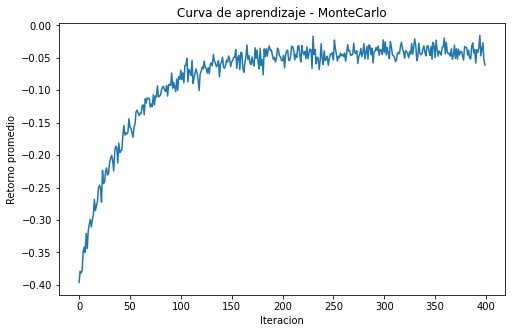

In [96]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo[0]))
plt.title('Curva de aprendizaje - MonteCarlo')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.show()
plt.close()

In [97]:
politica_optima_MonteCarlo = agente_MonteCarlo.q_function.argmax(3)
politica_optima_MC_df_dic = {}
for i in range(0,2):
  politica_optima_MC_df_dic[str(i)] = pd.DataFrame(data=politica_optima_MonteCarlo[:,:,i], 
                                       index=range(12,22), 
                                       columns=['A']+[str(x) for x in range(2,11)])

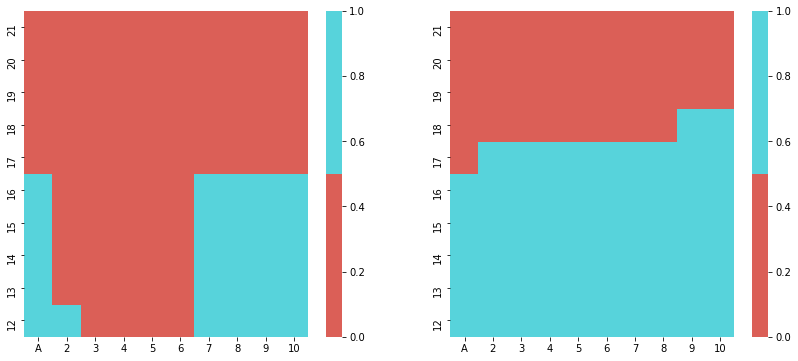

In [98]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in range(0,2):
  sns_ax = sns.heatmap(politica_optima_MC_df_dic[str(i)], ax=ax[i], cmap=sns.color_palette("hls", 2))
  sns_ax.invert_yaxis()
plt.show()
plt.close()